In [1]:
# Import torch, torchvision and other libraries
import torch
import torch.nn.functional as F
import torchvision

import numpy as np
import matplotlib.pyplot as plt

In [2]:
from matplotlib.animation import FuncAnimation, PillowWriter
from functools import partial

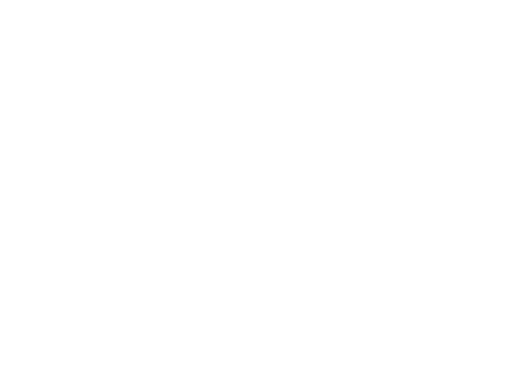

In [39]:
g = 9.81  # Acceleration due to gravity (m/s^2)
l = 1.0   # Length of the pendulum (m)
theta = np.pi / 4  # Initial angle (radians)
omega = 0.0        # Initial angular velocity (rad/s)
dt = 0.01          # Time step (s)

# Initialize figure and axis
fig, ax = plt.subplots()
ax.set_xlim(-1.2 * l, 1.2 * l)
ax.set_ylim(-1.2 * l, 0.6 * l)
ax.set_aspect('equal')
ax.axis('off')

# Create a line to represent the pendulum
line, = ax.plot([], [], lw=2)

# Function to initialize the animation
def init():
    line.set_data([], [])
    return line,

# Parameters for the Gaussian sampling
N = 100  # Number of points to sample per frame
sigma = 0.2  # Standard deviation of the Gaussian noise

# Initialize the data matrix
num_frames = 200
data_matrix = np.zeros((N, num_frames, 2))

# Function to update the animation and generate sampled points
def update_with_sampling(frame):
    global theta, omega
    alpha = -g / l * np.sin(theta)  # Angular acceleration
    omega += alpha * dt            # Update angular velocity
    theta += omega * dt            # Update angle

    # Calculate pendulum position
    x = l * np.sin(theta)
    y = -l * np.cos(theta)
    line.set_data([0, x], [0, y])

    # Sample N points around the pendulum position
    lengths = np.random.uniform(0, l, size=N)  # Random distances along the string
    angles = np.random.normal(loc=theta, scale=sigma, size=N)  # Small angular deviations
    sampled_x = lengths * np.sin(angles)
    sampled_y = -lengths * np.cos(angles)
    sampled_points = np.stack((sampled_x, sampled_y), axis=1)
    data_matrix[:, frame, :] = sampled_points

    return line,

lengths = np.random.uniform(0, l, size=N)  # Random distances along the string
angles = np.random.normal(loc=theta, scale=sigma, size=N)  # Small angular deviations
angle_matrix = np.zeros((N, num_frames))
angle_matrix[:, 0] = angles

def update_with_single_sampling(frame):
    global theta, omega
    alpha = -g / l * np.sin(theta)  # Angular acceleration
    omega += alpha * dt            # Update angular velocity
    theta += omega * dt            # Update angle

    # Calculate pendulum position
    x = l * np.sin(theta)
    y = -l * np.cos(theta)
    line.set_data([0, x], [0, y])

    # Evolve the angle_matrix
    if frame > 0:
        prev_angle = angle_matrix[:, frame - 1]
        new_angle = prev_angle + omega * dt
        angle_matrix[:, frame] = new_angle
        # if frame % 10 == 0:
        #     print(f'Frame {frame}: {new_angle[:5]}')

    return line,

# Create the animation
# update_fn = partial(update_with_single_sampling, theta=theta, omega=omega, angle_matrix=angle_matrix)
ani = FuncAnimation(fig, update_with_single_sampling, frames=range(num_frames), init_func=init, blit=False, interval=dt * 1000)


plt.show()
ani.save('pendulum.gif', writer='pillow', fps=20)
np.save('pendulum.npy', data_matrix)

In [40]:
# Use angle_matrix to get data_matrix
for i in range(num_frames):
    x = lengths * np.sin(angle_matrix[:, i])
    y = -lengths * np.cos(angle_matrix[:, i])
    if i < 5:
        print(f'Frame {i}: {x[:5]}')
    data_matrix[:, i, :] = np.stack((x, y), axis=1)

np.save('pendulum.npy', data_matrix)
print('Saved pendulum.npy')

Frame 0: [0.06181003 0.26817835 0.25951586 0.30907042 0.4238709 ]
Frame 1: [0.0617175  0.26793794 0.25907791 0.30867375 0.42294986]
Frame 2: [0.06157856 0.26757657 0.25842043 0.30807798 0.42156758]
Frame 3: [0.06139304 0.26709335 0.25754277 0.3072822  0.4197232 ]
Frame 4: [0.06116073 0.26648707 0.25644407 0.3062852  0.41741563]
Saved pendulum.npy


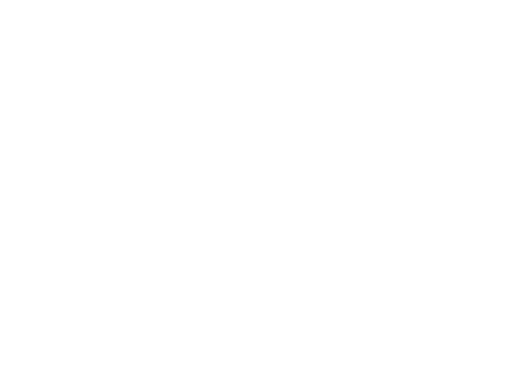

In [41]:
# Load the data matrix and visualize the sampled points
data_matrix = np.load('pendulum.npy')
fig, ax = plt.subplots()
ax.set_xlim(-1.2 * l, 1.2 * l)
ax.set_ylim(-1.2 * l, 0.6 * l)
ax.set_aspect('equal')
ax.axis('off')

# Create a scatter plot to visualize the sampled points
scat = ax.scatter([], [], s=2)

# Function to initialize the animation
def init(): 
    return scat,

# Function to update the animation
def update(frame):
    scat.set_offsets(data_matrix[:, frame, :])
    return scat,

# Create the animation
ani = FuncAnimation(fig, update, frames=range(num_frames), init_func=init, blit=False, interval=dt * 1000)
plt.show()
ani.save('pendulum_sampling.gif', writer='pillow', fps=20)


In [ ]:
# Compute pointwise pca of data_matrix at each frame
from sklearn.decomposition import PCA

pca = PCA(n_components=1)
rank1_approximations = np.zeros((N, num_frames, 2))
for i in range(num_frames):
    frame_data = data_matrix[:, i, :]
    pca.fit(frame_data)
    rank1_approximations[:, i, :] = pca.mean_ + pca.components_[0] * pca.transform(frame_data)


<Figure size 1200x800 with 0 Axes>

In [35]:
def video_plot(n_plots, approximations, data_matrix, num_frames, fname='pendulum_sampling'):
    frame_to_display = np.linspace(0, num_frames - 1, n_plots).astype(int) / num_frames
    plt.figure(figsize=(12, 8))

    for i, frame in enumerate(frame_to_display):
        plt.figure(figsize=(12, 8))
        plt.xlim(-l,  l)
        plt.ylim(-l, 0.3 * l)
        plt.axis('off')
        plt.scatter(data_matrix[:, int(frame * num_frames), 0], data_matrix[:, int(frame * num_frames), 1], s=6, label='Original')
        plt.scatter(approximations[:, int(frame * num_frames), 0], approximations[:, int(frame * num_frames), 1], s=6, label='Rank-1 Approximation')
        plt.legend()
        plt.savefig(f'./figures/{fname}_{i}.png')
        plt.close()

video_plot(10, rank1_approximations, data_matrix, num_frames)

<Figure size 1200x800 with 0 Axes>

In [51]:
print(pca.components_)
last_data = data_matrix[:, -1, :]
l_data_cen = last_data - np.mean(last_data, axis=0)
# SVD
U, S, V = np.linalg.svd(l_data_cen, full_matrices=False)
print(U.shape, S.shape, V.shape)
print(V)
print(S)
# Rank-1 svd
U1 = U[:, 0]
S1 = S[0]
V1 = V[0, :]

[[-0.27150752  0.96243632]]
(100, 2) (2,) (2, 2)
[[-0.27150752  0.96243632]
 [-0.96243632 -0.27150752]]
[2.67309963 1.13488043]


In [33]:
finite_diff_data = np.diff(data_matrix, axis=1)
def dynamic_low_rank_approx(U, S, V, tau=1.0):
    # U: N x r
    # S: r
    V = V.T # r x 2
    U_arr, S_arr, V_arr = [U], [S], [V]
    for i in range(num_frames-1):
        if i == 0:
            print(f"Shape U[-1]: {U_arr[-1].shape}, S[-1]: {S_arr[-1].shape}, V[-1]: {V_arr[-1].shape}")
        K = U_arr[-1] @ S_arr[-1] # N x r
        K_grad = finite_diff_data[:, i, :] @ V_arr[-1] # N x r
        K = K + tau * K_grad

        L = V_arr[-1] @ S_arr[-1] # 2 x r
        L_grad = finite_diff_data[:, i, :].T @ U_arr[-1] # 2 x r
        L = L + tau * L_grad

        U_new, _ = np.linalg.qr(K)
        V_new, _ = np.linalg.qr(L)
        M = U_new.T @ U_arr[-1]
        U_arr.append(U_new)
        N = V_new.T @ V_arr[-1]
        V_arr.append(V_new)

        tilde_S = M @ S_arr[-1] @ N
        S_grad = U_new.T @ finite_diff_data[:, i, :] @ V_new
        S_new = tilde_S + tau * S_grad
        S_arr.append(S_new)

    # Convert to numpy arrays
    U_arr = np.stack(U_arr, axis=0)
    S_arr = np.stack(S_arr, axis=0)
    V_arr = np.stack(V_arr, axis=0)
    return U_arr, S_arr, V_arr


first_data = data_matrix[:, 0, :]
first_data_cen = first_data - np.mean(first_data, axis=0)
# SVD
U, S, V = np.linalg.svd(first_data_cen, full_matrices=False)
U1 = U[:, 0]
S1 = S[0]
V1 = V[0, :]

Shape U[-1]: (100, 1), S[-1]: (1, 1), V[-1]: (2, 1)


<Figure size 1200x800 with 0 Axes>

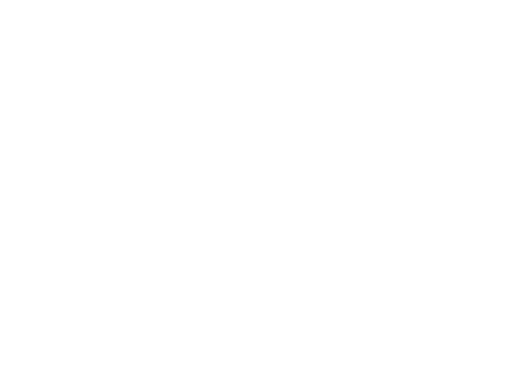

In [37]:
U_arr, S_arr, V_arr = dynamic_low_rank_approx(U1[:, None], np.array([[S1]]), V1[None, :], tau=1.0)
pca = PCA(n_components=1)
rank1_approximations = np.zeros((N, num_frames, 2))
for i in range(num_frames):
    frame_data = data_matrix[:, i, :]
    pca.fit(frame_data)
    rank1_approximations[:, i, :] = pca.mean_ + pca.components_[0] * pca.transform(frame_data)

# Rank1 approximation using dynamic low rank approximation
rank1_approximations_dynamic = np.zeros((N, num_frames, 2))
for i in range(num_frames):
    frame_data = data_matrix[:, i, :]
    rank1_approximations_dynamic[:, i, :] = U_arr[i] @ S_arr[i] @ V_arr[i].T + np.mean(frame_data, axis=0)

# fig, axs = plt.subplots(2, 3, figsize=(15, 10))
# for i, frame in enumerate(frame_to_display):
#     ax = axs[i // 3, i % 3]
#     ax.set_xlim(-1.2 * l, 1.2 * l)
#     ax.set_ylim(-1.2 * l, 1.2 * l)
#     ax.set_aspect('equal')
#     ax.axis('off')
#     ax.scatter(data_matrix[:, int(frame * num_frames), 0], data_matrix[:, int(frame * num_frames), 1], s=2, label='Original')
#     ax.scatter(rank1_approximations[:, int(frame * num_frames), 0], rank1_approximations[:, int(frame * num_frames), 1], s=2, label='Rank-1 Approximation')
#     ax.scatter(rank1_approximations_dynamic[:, int(frame * num_frames), 0], rank1_approximations_dynamic[:, int(frame * num_frames), 1], s=2, label='Dynamic Rank-1 Approximation')
#     ax.legend()

# plt.show()
video_plot(10, rank1_approximations_dynamic, data_matrix, num_frames, fname='pendulum_rank1_approx_dynamic')

# Animate the dynamic rank-1 approximation
fig, ax = plt.subplots()
ax.set_xlim(-1.2 * l, 1.2 * l)
ax.set_ylim(-1.2 * l, 0.6 * l)
ax.set_aspect('equal')
ax.axis('off')

# Create a scatter plot to visualize the sampled points
scat = ax.scatter([], [], s=2)

# Function to initialize the animation
def init(): 
    return scat,

# Function to update the animation
def update(frame):
    # scat.set_offsets(rank1_approximations_dynamic[:, frame, :])
    # Plot both dynamic rank-1 approximation and static rank-1 approximation
    scat.set_offsets(rank1_approximations_dynamic[:, frame, :])
    return scat,

# Create the animation
ani = FuncAnimation(fig, update, frames=range(num_frames), init_func=init, blit=False, interval=dt * 1000)
plt.show()
ani.save('pendulum_rank1_approx_dynamic.gif', writer='pillow', fps=20)

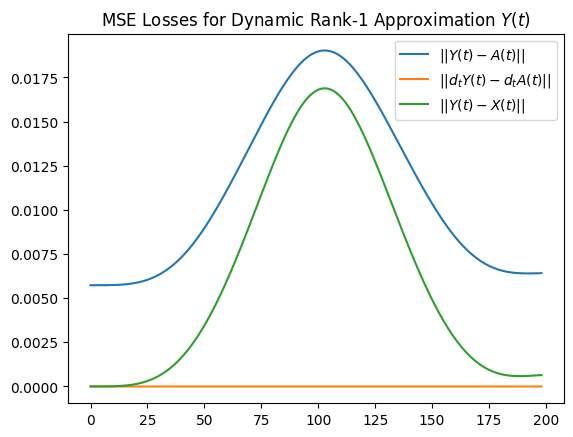

In [ ]:
# MSE Loss over time
mse_loss = np.zeros(num_frames-1)
deriv_mse_loss = np.zeros(num_frames-1)
mse_loss_dynamic = np.zeros(num_frames-1)
deriv_rank1_approximations = np.diff(rank1_approximations, axis=1)
deriv_data_matrix = np.diff(data_matrix, axis=1)
for i in range(num_frames-1):
    mse_loss[i] = np.mean(np.square(rank1_approximations_dynamic[:, i, :] - data_matrix[:, i, :]))
    deriv_mse_loss[i] = np.mean(np.square(deriv_rank1_approximations[:, i, :] - deriv_data_matrix[:, i, :]))
    mse_loss_dynamic[i] = np.mean(np.square(rank1_approximations_dynamic[:, i, :] - rank1_approximations[:, i, :]))

fig, ax = plt.subplots()

ax.plot(mse_loss, label='$||Y(t) - A(t)||$')
ax.plot(deriv_mse_loss, label='$||d_tY(t) - d_tA(t)||$')
ax.plot(mse_loss_dynamic, label='$||Y(t) - X(t)||$')
ax.title.set_text('MSE Losses for Dynamic Rank-1 Approximation $Y(t)$')
ax.legend()
plt.show()
plt.savefig('./figures/mse_losses.png')